In [1]:
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
from datetime import datetime
from multiprocessing.pool import ThreadPool
from shapely.geometry import Polygon, MultiPolygon, shape
from shapely import GEOSException
import plotly.express as px
import plotly.graph_objects as go

In [2]:
plt.rcParams['figure.figsize'] = [10, 5]
PARALLEL_PROCESSES = 16

## Read input files

In [52]:
novaya = pd.read_csv('dataset-territory.csv',
                     sep='\s+', skiprows=1, header=None,
                     names=['date', 'territory'], index_col='date',
                    infer_datetime_format=True, parse_dates=True)
novaya['territory'] = novaya['territory'].str.replace(',', '.').astype(float)

_novaya_filename = 'novaya-territory'
novaya.to_excel(f'{_novaya_filename}.xlsx')
novaya.to_csv(f'{_novaya_filename}.csv')

# Boundaries of Ukraine
ua_outline = gpd.read_file('stanford.geojson')
# CRS already set
# ua_outline = ua_outline.set_crs('EPSG:4326')
outline = ua_outline['geometry'].iloc[0]

with open('dump.pickle', 'rb') as f:
    processed = pickle.load(f)

df = pd.DataFrame(processed, columns=['id', 'date', 'area', 'features'])
df = df.drop(['id'], axis=1)
df = df.sort_values(by='date', ascending = True)
df = df.set_index('date')
df = df.rename(columns={'area': 'territory'})
df['territory'] = df['territory'].astype('float')
# Calculate change to previous day which translates to daily gains/losses
df['change'] = df['territory'].diff()

with open('nzz_area_occupied.json', 'rb') as f:
    nzz_raw = json.load(f)
nzz = pd.DataFrame.from_dict(nzz_raw, orient='index', columns=['territory'])
nzz.index = pd.to_datetime(nzz.index)
CRIMEA_AREA = 26689.32
nzz['territory'] = nzz['territory'] + CRIMEA_AREA

with open('nzz.pickle', 'rb') as f:
    nzz_dump = pickle.load(f)
nzz_df = pd.DataFrame(nzz_dump, columns=['id', 'date', 'area', 'features'])
nzz_df = nzz_df.drop(['id'], axis=1)
nzz_df = nzz_df.sort_values(by='date', ascending = True)
nzz_df = nzz_df.set_index('date')
nzz_df = nzz_df.rename(columns={'area': 'territory'})
nzz_df['territory'] = nzz_df['territory'].astype('float')

CRIMEA_AREA = 26689.32

nzz_df['territory'] = nzz_df['territory'] + CRIMEA_AREA
#nzz_df = nzz_df.drop(columns=['features'])
#_nzz_filename = 'nzz-territory'
#nzz_df.to_excel(f'{_nzz_filename}.xlsx')
#nzz_df.to_csv(f'{_nzz_filename}.csv')

# Smooth over outliers or faulty data

Data from 2022-05-15 until 2022-05-19 shows outlier spikes as well as 2022-08-25 which is most likely a bug and not reflective of actual battlefield developments. Fix this by backfilling data from the previous day.

In [53]:
adjusted = df.copy()
# Fix outliers
adjusted['2022-05-15':'2022-05-19'] = adjusted[adjusted.index == '2022-05-14'].values
adjusted.loc[adjusted.index == '2022-08-25'] = adjusted[adjusted.index == '2022-08-24'].values
# Recompute changed area
adjusted['change'] = adjusted['territory'].diff()
# df[(df.index <= datetime(2022, 5, 30)) & (df.index >= datetime(2022, 5, 1))]
# df['2022-05-10':'2022-05-30']

_liveuamap_adjusted_filename = 'liveuamap-territory-adjusted'
adjusted.to_excel(f'{_liveuamap_adjusted_filename}.xlsx')
adjusted.to_csv(f'{_liveuamap_adjusted_filename}.csv')

adjusted = adjusted['2022-02-24':]

combined = pd.concat([adjusted['territory'], nzz_df['territory']], axis=1, keys=['area_liveuamap', 'area_nzz'])

combined['avg'] = combined.median(axis=1, numeric_only=True)
combined['avg_change'] = combined['avg'].diff()

#nzz_comparison = adjusted['area'] - nzz['area']

## liveuamap territory calculation

In [6]:
def load_json(filename):
    with open('data/' + filename, 'r') as f:
        return json.load(f)

In [7]:
def get_coords(points):
    shapes = []
    if type(points[0]) is dict:
        coords = []
        for p in points:
            coords.append([p.get('lat'), p.get('lng')])
        shapes.append(coords)
        return shapes
    for p in points:
        shapes.append(np.column_stack([p[1::2], p[::2]]))
    return shapes

<Axes: >

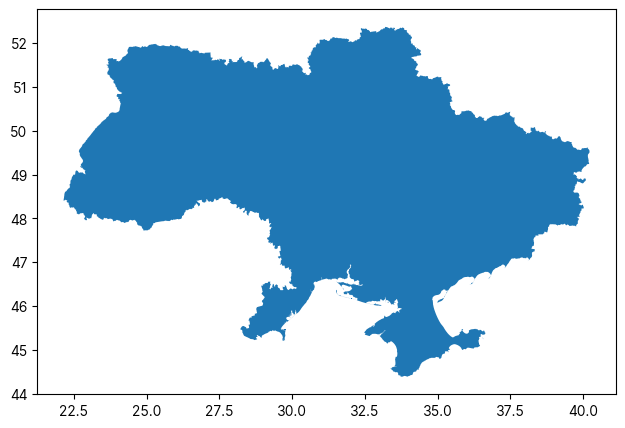

In [8]:
ua_outline.plot()

In [46]:
def extract_shapes(f):
    
    shape_dicts = [] 

    for field_id, field_dict in f['fields'].items():
        
        # Recaptured areas are not Russian-controlled, to skip them
        if field_dict.get('name') == 'Ukraine recaptured':
            continue
        # Same for "Territories, liberated from Russian forces"
        if 'liberated from Russian' in field_dict.get('description'):
            continue
        # Ignore incursions into Russian territory (should be omitted through
        # intersections with Ukraine boundary file anyway)
        if field_dict.get('name') == 'Freedom Of Russia and RDK':
            continue
        if field_dict.get('name') == 'Transnistria':
            continue
        # Skip Russian territory which might intersect due to boundary issues
        if 'region of Russia' in field_dict.get('name'):
            continue
        # Same for "Territories, liberated from Russian forces"
        if 'liberated from Russian' in field_dict.get('description'):
            continue

        c = get_coords(field_dict['points'])

        if len(c) == 0:
            # Simple polygon
            if len(c[0] >= 3):
                # Only at least 3 points can form a valid polygon, prevent errors later on
                polygon = Polygon(c[0])
        else:
            # Multiple polygons, to be combined
            polygon_list = []
            for coord_pair in c:
                if len(coord_pair) >= 4:
                    # Prevent 'ValueError: A linearring requires at least 4 coordinates.'
                    polygon_list.append(Polygon(coord_pair))
            polygon = MultiPolygon(polygon_list)

        shape_dict = dict(id=field_id, name=field_dict['name'], geometry=polygon)
        shape_dicts.append(shape_dict)
        
        # XXX TEMP: Get area of occupied Crimea
        #if field_dict.get('name') == 'Occupied Crimea':
        #    cea = gpd.GeoDataFrame([shape_dict])
        #    cea = cea.set_crs('EPSG:4326')
        #    cea = cea.to_crs({'proj':'cea'})
        #    print(f"Area of Crimea: {float(round(cea.area / 1e6, 2))}")
        # -> Area: 26689.32

    
    return shape_dicts

In [47]:
def process_item(args):
    idx, filename = args
    print(f"(Processing {idx}", end='\r')
    
    f = load_json(filename)
    id_ = filename.split('.json')[0]
    date = datetime.fromtimestamp(int(id_))
    
    shape_dicts = extract_shapes(f)
    
    ua_territory = gpd.GeoDataFrame(shape_dicts)
    ua_territory = ua_territory.set_crs('EPSG:4326')
    
    # Resolve some issues with data
    ua_territory['geometry'] = ua_territory.geometry.buffer(0)
    
    try:
        ua_territory['intersects'] = ua_territory['geometry'].intersects(outline)
    except GEOSException as e:
        print(f"filename: {filename}, Error: {e}")
        # In case of errors, show the affected area
        print(ua_territory)
        ua_territory.plot()
        raise
        
    # Drop areas entirely outside Ukrainian bounds
    # Prevents an error message when running .intersection() next
    ua_territory = ua_territory[ua_territory['intersects'] == True]
    # Reduce controlled areas to inside Ukrainian bounds
    try:
        ua_territory['geometry'] = ua_territory['geometry'].intersection(outline)
    except GEOSException as e:
        print(f"filename: {filename}, Error: {e}")
        # In case of errors, show the affected area
        print(ua_territory)
        ua_territory.plot()
        raise
        
    joined = ua_territory.dissolve(by=None).iloc[0]

    # Drop unneeded boolean column
    ua_territory = ua_territory.drop(['intersects'], axis=1)
    
    ua_territory = ua_territory.to_crs({'proj': 'cea'})
    ua_territory['area'] = ua_territory['geometry'].area / 10**6
    
    area = ua_territory['area'].sum()
    
    return [id_, date, area, joined]

In [48]:
processed = []
files = sorted(os.listdir('data'))

In [49]:
def dispatch(items):
    print(f"Processing all {len(items)} items...")
    return list(ThreadPool(
        PARALLEL_PROCESSES).imap_unordered(process_item, enumerate(items, 1)))

In [50]:
# XXX this may be slow, takes about 2min 
processed = dispatch(files[:])

Processing all 508 items...


In [51]:
with open('dump.pickle', 'wb') as f:
    pickle.dump(processed, f)

## Interactive visualization of territory on map

In [56]:
from ipyleaflet import (
    Map, GeoData, GeoJSON, basemaps, MagnifyingGlass, basemap_to_tiles,
    LayerGroup, SplitMapControl, LayersControl, LegendControl,
)
import ipywidgets

In [57]:
selection_slider = ipywidgets.SelectionSlider(options=list(adjusted.index),
                                              value=adjusted.index[0].to_pydatetime(), # datetime(2022, 2, 24),
                                              description='Slider',
                                              disabled=False,
                                              continuous_update=False,
                                              orientation='horizontal',
                                              readout=True)

In [54]:
adjusted

,territory,features,change
date,,,
2022-02-24,70156.563054,geometry MULTIPOLYGON (((30.20763969 45.2...,27175.571741
2022-02-25,72045.371074,geometry MULTIPOLYGON (((30.20763969 45.2...,1888.808020
2022-02-26,80495.873192,geometry MULTIPOLYGON (((30.20763969 45.2...,8450.502118
2022-02-27,84468.459062,geometry MULTIPOLYGON (((30.20763969 45.2...,3972.585870
2022-02-28,84926.105758,geometry MULTIPOLYGON (((30.20763969 45.2...,457.646696
...,...,...,...
2023-07-08,107674.879952,geometry MULTIPOLYGON (((32.0331955 46.17...,0.000000
2023-07-09,107674.879952,geometry MULTIPOLYGON (((32.0331955 46.17...,0.000000
2023-07-10,107674.879952,geometry MULTIPOLYGON (((32.0331955 46.17...,0.000000


In [58]:
m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=(48.1928465, 37.8562077), zoom=5)

def plot_date(date):
    entry = adjusted.loc[adjusted.index == date]
    idx, row = next(entry.iterrows())
    geo_data = GeoData(geo_dataframe=gpd.GeoDataFrame(
        geometry=[row['features']['geometry'],]  #gpd.GeoSeries(row['features']['geometry']))
    ))
    # Clear potential overlays from previous day selection
    m.clear_layers()
    m.add_layer(geo_data)

ipywidgets.interact(plot_date, date=selection_slider)
display(m)

interactive(children=(SelectionSlider(continuous_update=False, description='Slider', options=(Timestamp('2022-…

Map(center=[48.1928465, 37.8562077], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [73]:
adjusted['2023-07-01':]

,territory,features,change
date,,,
2023-07-01,107657.293696,geometry MULTIPOLYGON (((32.0331955 46.17...,0.000000
2023-07-02,107657.293696,geometry MULTIPOLYGON (((32.0331955 46.17...,0.000000
2023-07-03,107657.293696,geometry MULTIPOLYGON (((32.0331955 46.17...,0.000000
2023-07-04,107657.293696,geometry MULTIPOLYGON (((32.0331955 46.17...,0.000000
2023-07-05,107665.322921,geometry MULTIPOLYGON (((32.0331955 46.17...,8.029225
2023-07-06,107674.879952,geometry MULTIPOLYGON (((32.0331955 46.17...,9.557030
2023-07-07,107674.879952,geometry MULTIPOLYGON (((32.0331955 46.17...,0.000000
2023-07-08,107674.879952,geometry MULTIPOLYGON (((32.0331955 46.17...,0.000000
2023-07-09,107674.879952,geometry MULTIPOLYGON (((32.0331955 46.17...,0.000000


In [74]:
nzz_df['2023-07-01':]

,territory,features
date,,
2023-07-01,107250.521808,"[{'type': 'Feature', 'properties': {'type': 'n..."
2023-07-02,107250.521808,"[{'type': 'Feature', 'properties': {'type': 'n..."
2023-07-03,107250.521808,"[{'type': 'Feature', 'properties': {'type': 'n..."
2023-07-04,107196.327834,"[{'type': 'Feature', 'properties': {'type': 'n..."
2023-07-05,107196.327834,"[{'type': 'Feature', 'properties': {'type': 'n..."
2023-07-06,107225.200762,"[{'type': 'Feature', 'properties': {'type': 'n..."
2023-07-07,107225.200762,"[{'type': 'Feature', 'properties': {'type': 'n..."
2023-07-08,107213.900194,"[{'type': 'Feature', 'properties': {'type': 'n..."
2023-07-09,107213.900194,"[{'type': 'Feature', 'properties': {'type': 'n..."


In [79]:
selection_slider = ipywidgets.SelectionSlider(options=list(adjusted.index)[490:],
                                              value=adjusted.index[491].to_pydatetime(), # datetime(2022, 2, 24),
                                              description='Slider',
                                              disabled=False,
                                              continuous_update=False,
                                              orientation='horizontal',
                                              readout=True)

m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=(48.1928465, 37.8562077), zoom=5)

#bg = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)
#m.add_layer(bg)

lg_liveuamap = LayerGroup(name='liveuamap', layers=[])
m.add_layer(lg_liveuamap)
lg_nzz = LayerGroup(name='NZZ', layers=[])
m.add_layer(lg_nzz)
#control = SplitMapControl(left_layer=lg_nzz, right_layer=lg_liveuamap)
lcontrol = LayersControl(position='topright')
#control = SplitMapControl(left_layer=lg_liveuamap, right_layer=lg_nzz)
#m.add_control(control)
m.add_control(lcontrol)
legend = LegendControl({"NZZ":"red", "liveuamap": "blue"}, name="Legend", position="bottomright")
m.add_control(legend)
    
def plot_liveuamap(date):
    entry = adjusted.loc[adjusted.index == date]
    idx, row = next(entry.iterrows())
    geo_data = GeoData(
        geo_dataframe=gpd.GeoDataFrame(geometry=[row['features']['geometry'],],),
        style={
            'color': 'blue',
            'fillcolor': 'blue',
            'opacity': 1.0,
        },
    )
    #print(str(geo_data)[:100])
    # Clear potential overlays from previous day selection
    lg_liveuamap.clear_layers()
    lg_liveuamap.add_layer(geo_data)

def plot_nzz(date):
    entry = nzz_df.loc[nzz_df.index == date]
    idx, row = next(entry.iterrows())
    features = row.loc['features']
    fc =   {
        'type': 'FeatureCollection',
        'features': features,
    }
    geo_json = GeoJSON(
        data=fc,
        style={
            'color': 'red',
            'fillcolor': 'red',
            'opacity': 0.5,
        },
    )
    # Clear potential overlays from previous day selection
    lg_nzz.clear_layers()
    lg_nzz.add_layer(geo_json)
    
def plot_date(date):
    plot_liveuamap(date)
    plot_nzz(date)

ipywidgets.interact(plot_date, date=selection_slider)
display(m)

# control = SplitMapControl(left_layer=lg_liveuamap, right_layer=lg_nzz)
#m.add_control(control)
#ipywidgets.HBox([m, Map(center=[43.6, 1.44], zoom=10)])

interactive(children=(SelectionSlider(continuous_update=False, description='Slider', index=1, options=(Timesta…

Map(center=[48.1928465, 37.8562077], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

## Analysis and plots

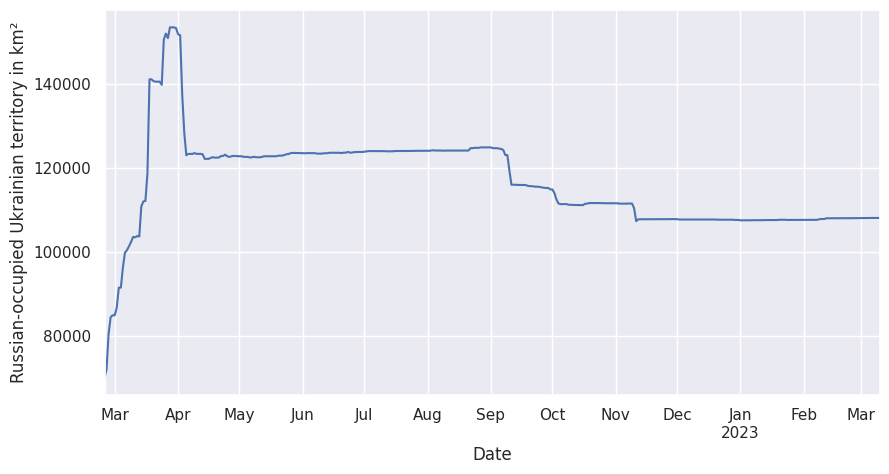

In [27]:
plt.figure() #  figsize=(12, 5)
adjusted['area'].plot(xlabel='Date', ylabel='Russian-occupied Ukrainian territory in km\u00b2')
plt.savefig('liveuamap_area_total.svg', bbox_inches='tight', dpi=600)
plt.savefig('liveuamap_area_total.png', bbox_inches='tight', dpi=600)

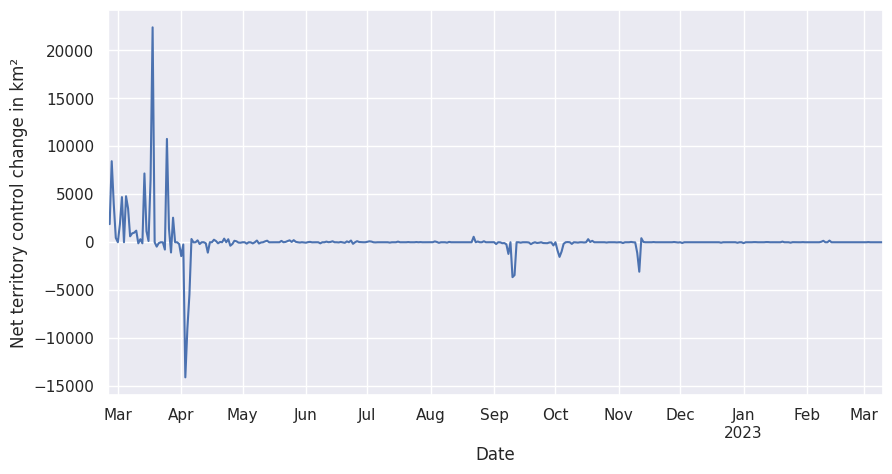

In [28]:
plt.figure()
adjusted['change'].plot(xlabel='Date', ylabel='Net territory control change in km\u00b2')
plt.savefig('liveuamap_area_net.svg', bbox_inches='tight', dpi=600)
plt.savefig('liveuamap_area_net.png', bbox_inches='tight', dpi=600)

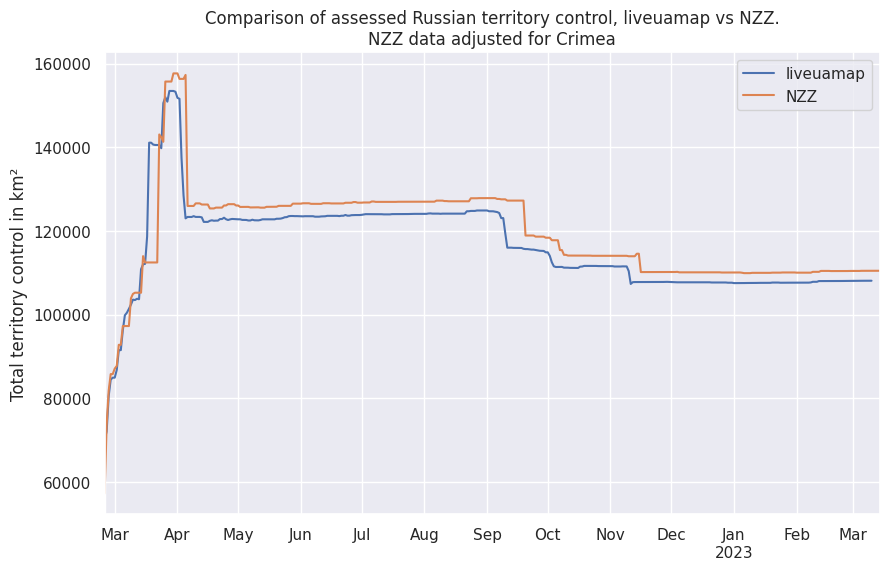

In [60]:
plt.figure()
ax = adjusted['area'].plot(xlabel='', ylabel='Total territory control in km\u00b2', figsize=(10, 6))
nzz['area'].plot(ax=ax)
plt.title('Comparison of assessed Russian territory control, liveuamap vs NZZ.\nNZZ data adjusted for Crimea')
ax.legend(['liveuamap', 'NZZ'], loc='upper right')
plt.savefig('liveuamap_nzz_area_comparison_total.svg', bbox_inches='tight', dpi=600)
plt.savefig('liveuamap_nzz_area_comparison_total.png', bbox_inches='tight', dpi=600)
plt.show()

Text(0.5, 1.0, 'Difference in NZZ vs liveuamap total territory control in km²')

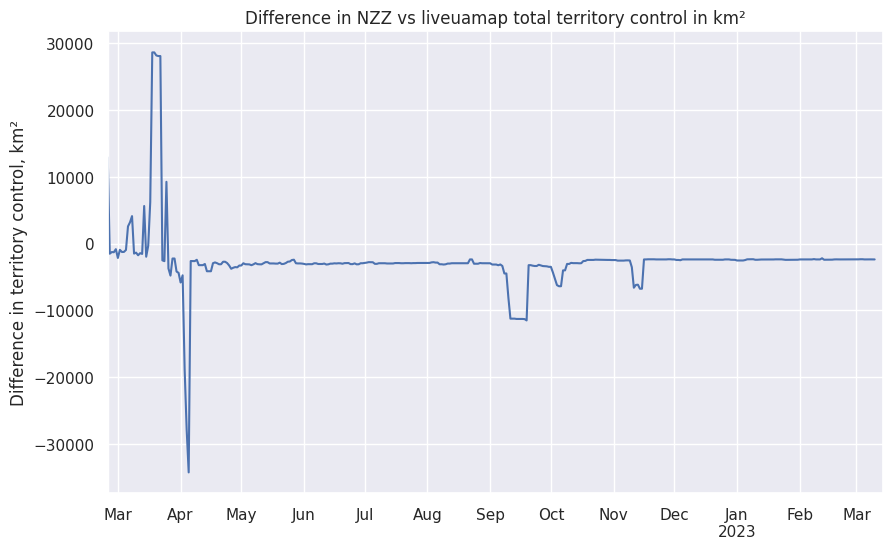

In [39]:
plt.figure()
nzz_comparison.plot(xlabel='', ylabel='Difference in territory control, km\u00b2', figsize=(10, 6))
plt.title('Difference in NZZ vs liveuamap total territory control in km\u00b2')

<Figure size 1000x500 with 0 Axes>

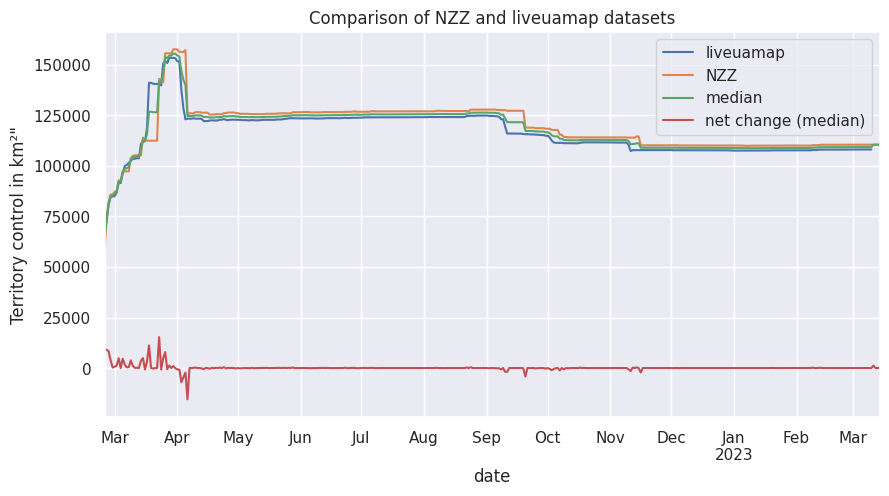

In [45]:
plt.figure()
ax = combined.plot(figsize=(10, 5))
plt.title('Comparison of NZZ and liveuamap datasets')
ax.set_ylabel('Territory control in km\u00b2"')
#ax.legend(['Total territory control (averaged) in km\u00b2'], loc='best')
ax.legend([
    'liveuamap',
    'NZZ',
    'median',
    'net change (median)',
])
plt.savefig('comparison_liveuamap_nzz_median.svg', bbox_inches='tight', dpi=600)
plt.savefig('comparison_liveuamap_nzz_median.png', bbox_inches='tight', dpi=600)

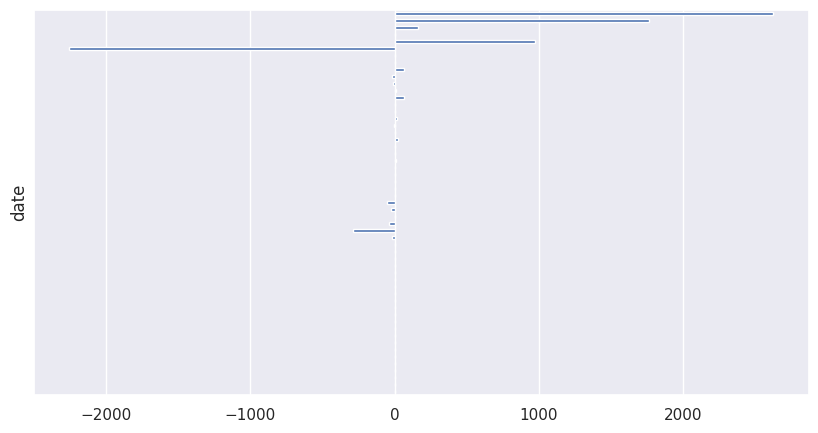

In [51]:
import matplotlib.dates as mdates

plt.figure(figsize=(10, 5))
resampled = combined['avg_change'].resample("7D").median()
# ax = resampled[::-1].plot.bar()
ax = resampled.plot.barh()
ax.set_yticks([])

# Set major and minor date tick locators
#maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,2))
#ax.yaxis.set_major_locator(maj_loc)
#min_loc = mdates.MonthLocator()
#ax.yaxis.set_minor_locator(min_loc)

# Set major date tick formatter
#zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
#maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, show_offset=False)
#ax.yaxis.set_major_formatter(maj_fmt)

# ax.figure.autofmt_xdate(rotation=90, ha='center')
# ax.set_xlim(combined.index.min(), combined.index.max());

plt.gca().invert_yaxis()

plt.savefig('net_change_barh.svg', bbox_inches='tight', dpi=600)
plt.savefig('net_change_barh.png', bbox_inches='tight', dpi=600)

In [59]:
#import pylab as pl
#plt.figure()
#ax = plt.gca()
#ax.hexbin(pl.date2num(combined.index), pl.date2num(combined['avg_change']), gridsize=20)
#ax.xaxis_date()
#ax.yaxis_date()
#ax.xaxis.major.formatter.scaled[1.0] = "%Y-%m-%d"
#ax.yaxis.major.formatter.scaled[1.0] = "%Y-%m-%d"
#pl.xticks(rotation=45)

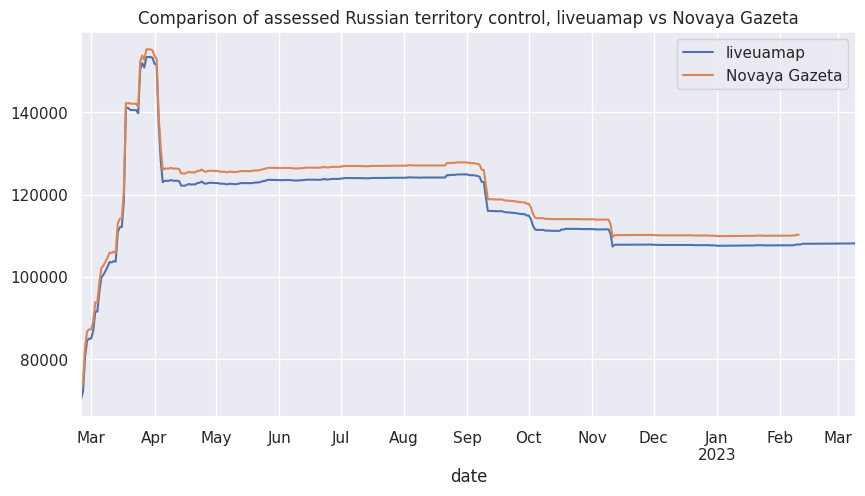

In [54]:
plt.figure()
ax = adjusted['area'].plot()
novaya['territory'].plot(ax=ax)
plt.title('Comparison of assessed Russian territory control, liveuamap vs Novaya Gazeta')
ax.legend(['liveuamap', 'Novaya Gazeta'], loc='upper right')
plt.savefig('liveuamap_novaya_area_comparison_total.svg', bbox_inches='tight', dpi=600)
plt.savefig('liveuamap_novaya_area_comparison_total.png', bbox_inches='tight', dpi=600)
plt.show()

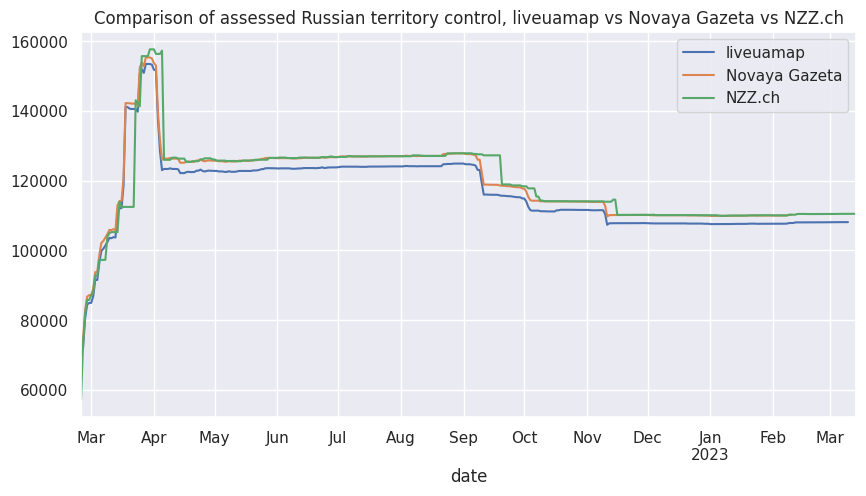

In [61]:
plt.figure()
ax = adjusted['area'].plot()
novaya['territory'].plot(ax=ax)
nzz['area'].plot(ax=ax)

plt.title('Comparison of assessed Russian territory control, liveuamap vs Novaya Gazeta vs NZZ.ch')
ax.legend(['liveuamap', 'Novaya Gazeta', 'NZZ.ch'], loc='upper right')
plt.savefig('liveuamap_novaya_nzz_area_comparison_total.svg', bbox_inches='tight', dpi=600)
plt.savefig('liveuamap_novaya_nzz_area_comparison_total.png', bbox_inches='tight', dpi=600)
plt.show()

In [44]:
_liveuamap = adjusted['area']
_ng = novaya['territory']
_nzz = nzz['area']

In [3]:
df = pd.read_csv('territory.csv', parse_dates=True)

In [8]:
df.set_index('date').index.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

,date,area
0,2022-02-20 00:00:00,43021.424
1,2022-02-21 00:00:00,43021.424
2,2022-02-22 00:00:00,43021.424
3,2022-02-23 00:00:00,43021.424
4,2022-02-24 00:00:00,70196.996
...,...,...
504,2023-05-09 22:00:00,108429.495
505,2023-05-10 00:00:00,108409.791
506,2023-05-11 00:00:00,108409.791
507,2023-05-12 00:00:00,108380.614
